In [2]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import openpyxl

# load data
conn = sqlite3.connect('./Data/database.sqlite')
with sqlite3.connect('./Data/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    player = pd.read_sql_query("SELECT * from Player", con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes", con)



In [3]:
matches['year'] = matches['date'].str[:4]
selected_countries = ['England','France','Germany','Italy','Spain']
countries = countries[countries.name.isin(selected_countries)]
leagues = leagues[leagues.country_id.isin(countries.id)]
matches = matches[matches.league_id.isin(leagues.id)]

# drop na
matches = matches.dropna()
matches["winner"] = np.where(matches["home_team_goal"] > matches["away_team_goal"], 1, np.where(matches["home_team_goal"] < matches["away_team_goal"], 2, 0))

matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,year,winner
3248,3249,1729,1729,2012/2013,1,2012-08-18 00:00:00,1228229,9825,8472,0,...,4.75,8.50,1.35,4.60,9.00,1.40,4.33,8.50,2012,0
3249,3250,1729,1729,2012/2013,1,2012-08-20 00:00:00,1228230,8668,10260,1,...,3.70,1.87,4.60,3.50,1.83,4.00,3.40,1.91,2012,1
3250,3251,1729,1729,2012/2013,1,2012-08-18 00:00:00,1228231,9879,9850,5,...,3.75,4.75,1.80,3.50,4.40,1.83,3.50,4.33,2012,1
3251,3252,1729,1729,2012/2013,1,2012-08-19 00:00:00,1228232,8456,8466,3,...,7.00,19.00,1.18,6.25,16.00,1.17,6.50,17.00,2012,1
3252,3253,1729,1729,2012/2013,1,2012-08-18 00:00:00,1228233,10261,8586,2,...,3.40,2.75,2.60,3.30,2.75,2.50,3.40,2.70,2012,1


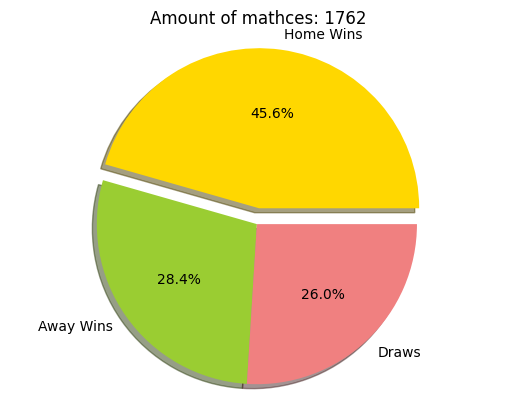

In [4]:
# pie chart of home wins, away wins, and draws
home_wins = len(matches[matches.winner == 1])
away_wins = len(matches[matches.winner == 2])
draws = len(matches[matches.winner == 0])
labels = 'Home Wins', 'Away Wins', 'Draws'
sizes = [home_wins, away_wins, draws]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Amount of mathces: %d' % (len(matches)))
plt.axis('equal')
plt.show()


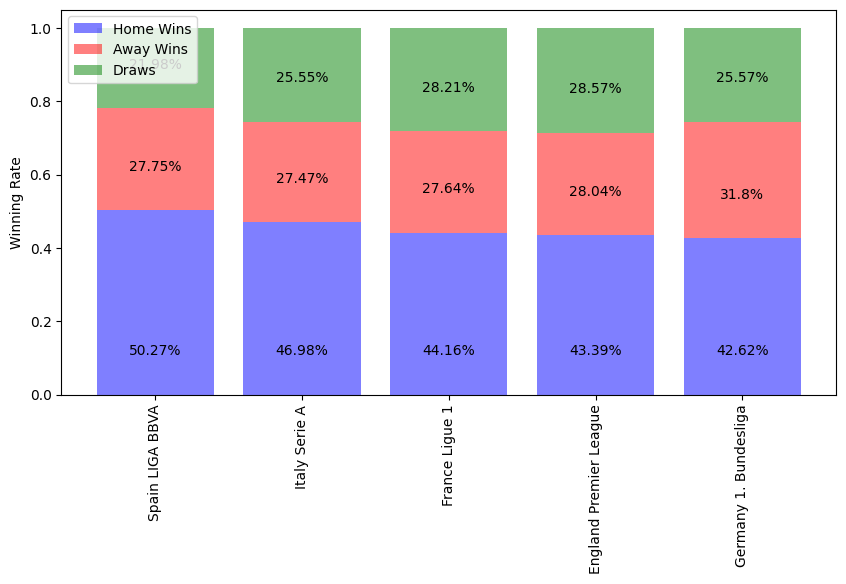

In [5]:
total_matches = matches.groupby('league_id').size()

# Calculate the winning rates for home teams, away teams, and draws for each league
home_wins = matches[matches.winner == 1].groupby('league_id').size() / total_matches
away_wins = matches[matches.winner == 2].groupby('league_id').size() / total_matches
draws = matches[matches.winner == 0].groupby('league_id').size() / total_matches

# Merge the winning rates into a DataFrame
winning_rates = pd.DataFrame({
    'Home Wins': home_wins,
    'Away Wins': away_wins,
    'Draws': draws,
    'Total Matches': total_matches
})

# Add league names to the DataFrame
winning_rates['League Name'] = leagues.set_index('id').loc[winning_rates.index]['name']

# Print the DataFrame

winning_rates = winning_rates.sort_values(by='Home Wins', ascending=False)
winning_rates = winning_rates.reset_index(drop=True)
winning_rates.head()

# Plot the winning rates
plt.figure(figsize=(10, 5))
plt.bar(winning_rates.index, winning_rates['Home Wins'], alpha=0.5, color='b', label='Home Wins')
plt.bar(winning_rates.index, winning_rates['Away Wins'], alpha=0.5, color='r', label='Away Wins', bottom=winning_rates['Home Wins'])
plt.bar(winning_rates.index, winning_rates['Draws'], alpha=0.5, color='g', label='Draws', bottom=winning_rates['Home Wins'] + winning_rates['Away Wins'])
# add text annotation corresponding to the percentage of each data.
for i in range(len(winning_rates)):
    plt.text(i, 0.1, str(round(winning_rates['Home Wins'][i] * 100, 2)) + '%', ha='center', va='bottom')
    plt.text(i, winning_rates['Home Wins'][i] + 0.1, str(round(winning_rates['Away Wins'][i] * 100, 2)) + '%', ha='center', va='bottom')
    plt.text(i, winning_rates['Home Wins'][i] + winning_rates['Away Wins'][i] + 0.1, str(round(winning_rates['Draws'][i] * 100, 2)) + '%', ha='center', va='bottom')
plt.xticks(winning_rates.index, winning_rates['League Name'], rotation=90)
plt.ylabel('Winning Rate')
plt.legend(loc='upper left')
plt.show()



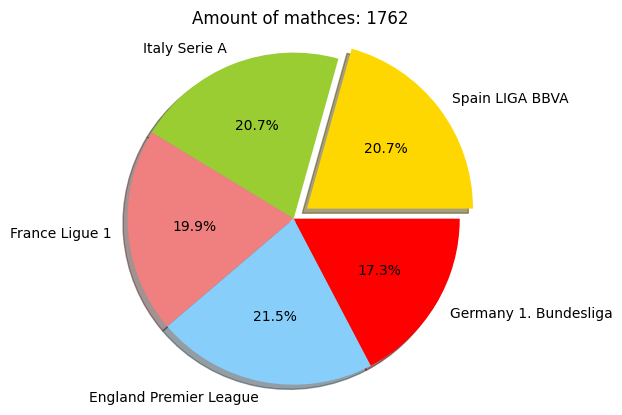

In [6]:
# plot the number of matches per league with pie chart

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = winning_rates['League Name']
sizes = winning_rates['Total Matches']
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 1st slice (i.e. 'Hogs')
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True)
plt.title('Amount of mathces: %d' % (len(matches)))
plt.axis('equal')
plt.show()

In [6]:
columns = matches.columns.tolist()
print(columns)

['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 'home_player_

In [7]:
# drop unnecessary columns
columns_to_drop = ['BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']
matches = matches.drop(columns_to_drop, axis=1)

# we keep the B365 odds for later comparison

In [8]:
# check na values in team attributes and player attributes
print(team_attributes.isna().sum())
print(player_attributes.isna().sum())

# drop na column
team_attributes = team_attributes.drop(['buildUpPlayDribbling'], axis=1)



id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64
id                        0
player_fi

In [9]:

# select matches from 2010 to 2015
matches = matches[matches.year.isin(['2010','2011','2012','2013','2014','2015'])]
print(matches.shape)



(1762, 90)


In [10]:
# remove useless columns
columns_to_drop = []

# remove columns related to the match result
columns_to_drop.append('home_team_goal')
columns_to_drop.append('away_team_goal')

for i in range (0, 11):
    columns_to_drop.append('home_player_X'+str(i+1))
    columns_to_drop.append('home_player_Y'+str(i+1))

    columns_to_drop.append('away_player_X'+str(i+1))
    columns_to_drop.append('away_player_Y'+str(i+1))
matches = matches.drop(columns_to_drop, axis=1)

In [11]:

# create a year column in team attributes and player attributes
# remove all old date columns of the same year but keep the most recent one
team_attributes['year'] = team_attributes['date'].str[:4]
team_attributes = team_attributes.drop_duplicates(subset=['team_api_id','year'], keep='last')

player_attributes['year'] = player_attributes['date'].str[:4]
player_attributes = player_attributes.drop_duplicates(subset=['player_api_id','year'], keep='last')



# merge team attributes and player attributes into matches

# merge team attributes
matches = matches.merge(team_attributes.add_prefix("home_team_"), left_on=['home_team_api_id','year'], right_on=['home_team_team_api_id','home_team_year'], how='left')
matches = matches.merge(team_attributes.add_prefix("away_team_"), left_on=['away_team_api_id','year'], right_on=['away_team_team_api_id','away_team_year'], how='left')

In [12]:
# merge player attributes
for i in range (0, 11):
    matches = matches.merge(player_attributes.add_prefix("home_player_"+str(i+1)+"_"), left_on=['home_player_'+str(i+1),'year'], right_on=['home_player_'+str(i+1)+'_player_api_id','home_player_'+str(i+1)+'_year'], how='left')
    matches = matches.merge(player_attributes.add_prefix("away_player_"+str(i+1)+"_"), left_on=['away_player_'+str(i+1),'year'], right_on=['away_player_'+str(i+1)+'_player_api_id','away_player_'+str(i+1)+'_year'], how='left')

In [15]:
# drop unnecessary columns
columns_to_drop = ["B365H", "B365D", "B365A", "year", "home_team_year", "away_team_year", "goal", "shoton", "shotoff",	"foulcommit", "card", "cross", "corner", "possession", "id", "country_id", "league_id", "season", "date", "home_team_date", "away_team_date"]


for i in range (0, 11):
    columns_to_drop.append("home_player_"+str(i+1)+"_date")
    columns_to_drop.append("away_player_"+str(i+1)+"_date")
    columns_to_drop.append("home_player_"+str(i+1)+"_year")
    columns_to_drop.append("away_player_"+str(i+1)+"_year")

matches = matches.drop(columns_to_drop, axis=1)

In [17]:
# encode categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

columns_to_encode = []
print(len(matches.columns.tolist()))

for i in range (0, 11):
    columns_to_encode.append("home_player_"+str(i+1)+"_preferred_foot")
    columns_to_encode.append("home_player_"+str(i+1)+"_attacking_work_rate")
    columns_to_encode.append("home_player_"+str(i+1)+"_defensive_work_rate")
    columns_to_encode.append("away_player_"+str(i+1)+"_preferred_foot")
    columns_to_encode.append("away_player_"+str(i+1)+"_attacking_work_rate")
    columns_to_encode.append("away_player_"+str(i+1)+"_defensive_work_rate")

for i in range (0, 1):
    columns_to_encode.append("home_team_"+"buildUpPlaySpeedClass")
    columns_to_encode.append("away_team_"+"buildUpPlaySpeedClass")
    columns_to_encode.append("home_team_"+"buildUpPlayPassingClass")
    columns_to_encode.append("away_team_"+"buildUpPlayPassingClass")
    columns_to_encode.append("home_team_"+"buildUpPlayDribblingClass")
    columns_to_encode.append("away_team_"+"buildUpPlayDribblingClass")
    columns_to_encode.append("home_team_"+"buildUpPlayPositioningClass")
    columns_to_encode.append("away_team_"+"buildUpPlayPositioningClass")
    columns_to_encode.append("home_team_"+"chanceCreationPassingClass")
    columns_to_encode.append("away_team_"+"chanceCreationPassingClass")
    columns_to_encode.append("home_team_"+"chanceCreationCrossingClass")
    columns_to_encode.append("away_team_"+"chanceCreationCrossingClass")
    columns_to_encode.append("home_team_"+"chanceCreationShootingClass")
    columns_to_encode.append("away_team_"+"chanceCreationShootingClass")
    columns_to_encode.append("home_team_"+"chanceCreationPositioningClass")
    columns_to_encode.append("away_team_"+"chanceCreationPositioningClass")
    columns_to_encode.append("home_team_"+"defencePressureClass")
    columns_to_encode.append("away_team_"+"defencePressureClass")
    columns_to_encode.append("home_team_"+"defenceAggressionClass")
    columns_to_encode.append("away_team_"+"defenceAggressionClass")
    columns_to_encode.append("home_team_"+"defenceTeamWidthClass")
    columns_to_encode.append("away_team_"+"defenceTeamWidthClass")
    columns_to_encode.append("home_team_"+"defenceDefenderLineClass")
    columns_to_encode.append("away_team_"+"defenceDefenderLineClass")




for column in columns_to_encode:
    matches[column] = le.fit_transform(matches[column])


['stage', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'winner', 'home_team_id', 'home_team_team_fifa_api_id', 'home_team_team_api_id', 'home_team_buildUpPlaySpeed', 'home_team_buildUpPlaySpeedClass', 'home_team_buildUpPlayDribblingClass', 'home_team_buildUpPlayPassing', 'home_team_buildUpPlayPassingClass', 'home_team_buildUpPlayPositioningClass', 'home_team_chanceCreationPassing', 'home_team_chanceCreationPassingClass', 'home_team_chanceCreationCrossing', 'home_team_chanceCreationCrossingClass', 'home_team_chanceCreationShooting', 'home_team_chanceCreationShootingClass', 'home_team_chanceCreationPositio

In [20]:
# train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(matches, test_size=0.2, random_state=42)

# xgboost

import xgboost as xgb
from sklearn.metrics import accuracy_score

y = train['winner']
X = train.drop("winner", axis=1)

y_test = test['winner']
X_test = test.drop("winner", axis=1)

# fit model no training data
model = xgb.XGBClassifier()
model.fit(X, y)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))




Accuracy: 45.61%
